In [43]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
pipeline = pipeline.to("cuda")

unet/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [85]:
import os
a = "/DATA_17/kjw/SD_pilottest/input_img/crop"
b = os.listdir(a)
sorted(b, key=lambda x: int(os.path.splitext(x)[0]))

['0.jpg',
 '1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg']

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [9]:
img = Image.open('/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-11-_png_jpg.rf.1c677db4c8a8d80f34e89c532636dd3c.jpg')
area = (180, 200, 400, 550)
img2 = img.crop(area)
area = (50, 50, 150, 150)
x1, y1, x2, y2 = area

In [10]:
img = Image.open('/DATA_17/kjw/SD_pilottest/input_img/original/12.jpg')

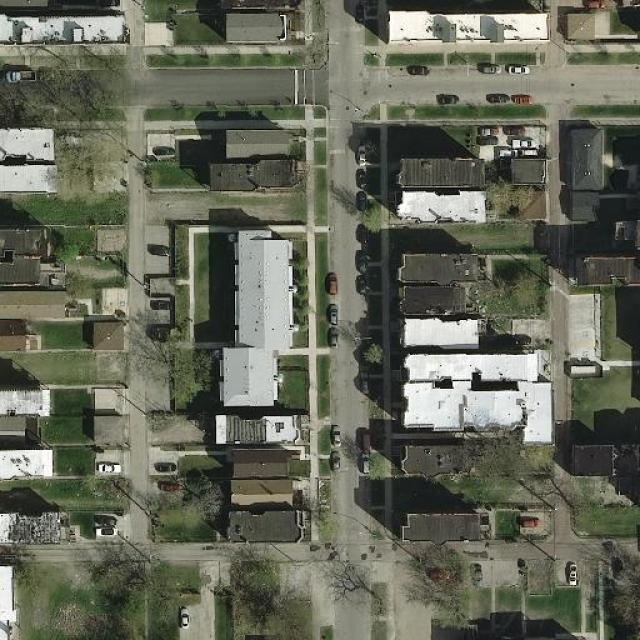

In [11]:
img

In [72]:
area = (200, 190, 230, 250)
x1, y1, x2, y2 = area
np_mask = np.zeros(img.size)
np_mask[y1:y2, x1:x2] = 1
binarr = np.where(np_mask>0, 255, 0)
mask_image = Image.fromarray(binarr.astype(np.uint8))
# img = img.resize((512,512))
# mask_image = mask_image.resize((512,512))

In [76]:
# prompt = "this picture is an aerial photo, draw me a picture of the building with heavy smoke"
# prompt = "This is an aerial photo, draw a picture of a building with smoke in it."
# prompt = "This is an aerial photo, draw me a bombed-out building."
# mask_image = Image.open('/DATA_17/kjw/SD_pilottest/input_img/mask/18.jpg')
# img = Image.open('/DATA_17/kjw/SD_pilottest/input_img/original/12.jpg')
prompt = "Draw a picture of a big fire with smoke."
# prompt = "color me just blue"
# prompt = "Draw a picture of a liquid leaking"
# prompt = "This image is an aerial view. Draw me a picture of the roof of a building completely destroyed."
# prompt = "Draw a picture of a large hole in the roof of a building caused by an air strike."
# prompt = "Draw a picture of a large hole in the roof of a building from an air strike."
# prompt = "Draw me a picture of a building with a massive and deep hole on it"
# prompt = ["Draw me a picture of a building with a big sink hole in it", "Draw me a picture of a building on fire"]
mask_image = mask_image.resize((512, 512))
img = img.resize((512, 512))
image = pipeline(prompt=prompt, image=img, mask_image=mask_image)#.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

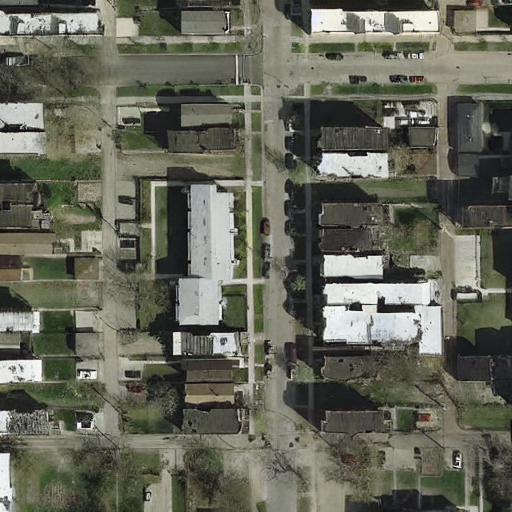

In [75]:
image.images[0]

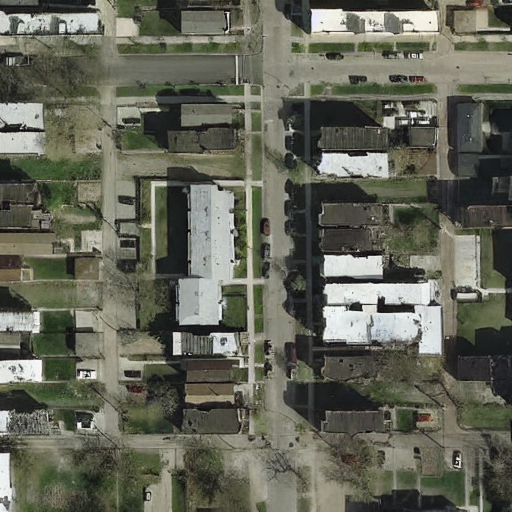

In [77]:
image.images[0]

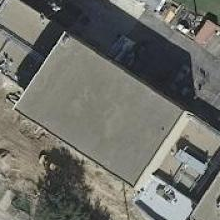

In [67]:
img2

In [68]:
mask_img = img2.crop(area)

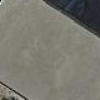

In [69]:
mask_img

In [70]:
# np_mask = np.array(mask_img)

In [71]:
np_mask = np.zeros(img2.size)

In [72]:
np_mask[y1:y2, x1:x2] = 1

In [73]:
binarr = np.where(np_mask>0, 255, 0)

In [74]:
# White to change & black to mask

mask_image = Image.fromarray(binarr.astype(np.uint8))
img2 = img2.resize((512,512))
mask_image = mask_image.resize((512,512))

In [92]:
# prompt = "this picture is an aerial photo, draw me a picture of the building with heavy smoke"
# prompt = "This is an aerial photo, draw a picture of a building with smoke in it."
# prompt = "This is an aerial photo, draw me a bombed-out building."
# prompt = "Draw me a picture of a building on fire"
prompt = ["Draw me a picture of a building with a sink hole in it", "Draw me a picture of a building on fire"]
image = pipeline(prompt=prompt, image=img2, mask_image=mask_image)#.images[0]

NameError: name 'pipeline' is not defined

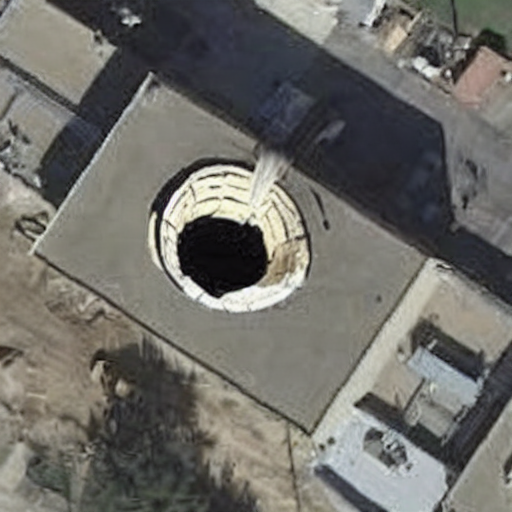

In [76]:
image

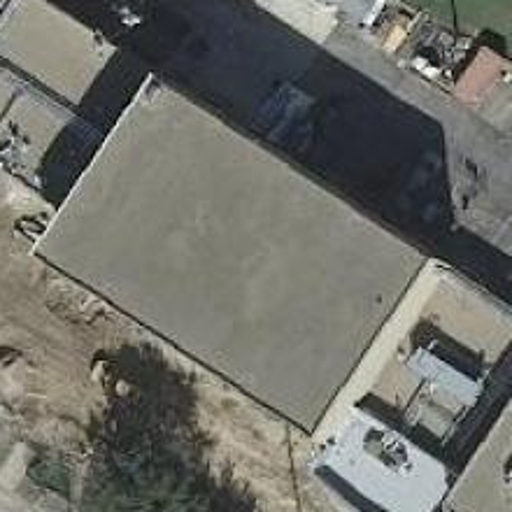

In [225]:
img2

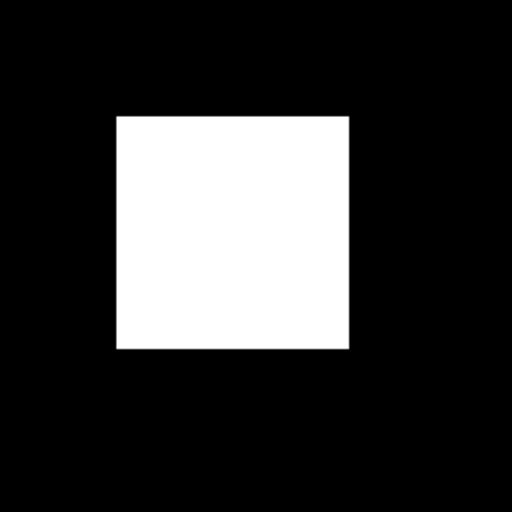

In [218]:
mask_image

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

img = Image.open('/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-11-_png_jpg.rf.1c677db4c8a8d80f34e89c532636dd3c.jpg')

In [6]:
def on_mouse_move(event):
    print('Event received:',event.x,event.y)

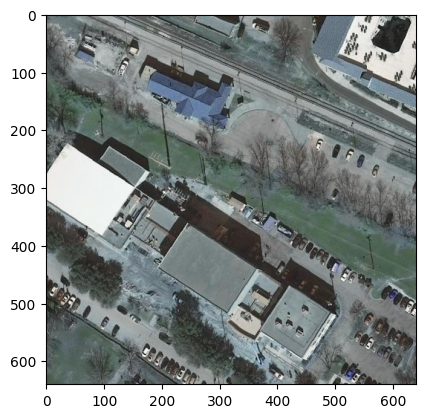

In [10]:
img = Image.open('/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-11-_png_jpg.rf.1c677db4c8a8d80f34e89c532636dd3c.jpg')
np_img = np.array(img)
opencv_image=cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
plt.imshow(opencv_image)

plt.connect('motion_notify_event',on_mouse_move)
plt.show()
# a = input("insert top-left and bottom-right coordinates of building: (x1,y1) and (x2, y2)")
# plt.close()

In [2]:
import os
import cv2
import shutil
from PIL import Image
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets.widgets import Button, Dropdown, VBox, HBox
from skimage.draw import polygon


class SegmentWidget:
    
    def __init__(self, path_imgs, id=None, path_masks='input_img/mask'):
        
        self._path_imgs = path_imgs
        self._path_masks = path_masks
        self._ids = sorted([int(os.path.splitext(e)[0]) for e in  os.listdir(path_imgs)], key=int)
        self._current_id = self._ids[0]
        #This list will be used later to save in memory the coordinates 
        #of the clicks by the user
        self._polygon_coordinates = []
        #TODO: Initiation of all the layout components
        self._initialize_widget()


    def _load_images(self):
        '''This method will be used to load image and mask when we select another image'''
        # img_path = os.path.join(self._path_imgs,f"{self._current_id}.npy")
        # self._current_img = np.load(img_path)
        img = Image.open(os.path.join(self._path_imgs, f'{self._current_id}.jpg'))
        # shutil.copyfile(self._path_imgs, os.path.join('/DATA_17/kjw/SD_pilottest/input_img/original', str(self._current_id)+'.jpg'))
        np_img = np.array(img)
        self._current_img=cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
        h,w, _ = self._current_img.shape
        
        #There is not always a mask saved. When no mask is saved, we create an empty one.
        # mask_path = os.path.join(self._path_masks,f"{self._current_id}.npy")
        # if os.path.exists(mask_path):
        #     self._current_mask = np.load(mask_path)
        # else:
        self._current_mask = np.zeros((h,w))
        #initiate an intermediate mask which will be used to store ongoing work
        self._intermediate_mask = self._current_mask.copy()

    def _initialize_figures(self):
        '''This function is called to initialize the figure and its callback'''
        self._image_fig = go.FigureWidget()
        self._mask_fig = go.FigureWidget()

        self._load_images() #Update the state loading the images

        #We use plotly express to generate the RGB image from the 3D array loaded
        img_trace = px.imshow(self._current_img).data[0]
        #We use plotly HeatMap for the 2D mask array
        mask_trace = go.Heatmap(z=self._current_mask, showscale=False, zmin=0, zmax=1)
        
        #Add the traces
        self._image_fig.add_trace(img_trace)
        self._image_fig.add_trace(mask_trace)
        self._mask_fig.add_trace(mask_trace)
        
        #A bit of chart formating
        self._image_fig.data[1].opacity = 0.3 #make the mask transparent on image 1
        self._image_fig.data[1].zmax = 2 #the overlayed mask above the image can have values in range 0..2
        self._image_fig.update_xaxes(visible=False)
        self._image_fig.update_yaxes(visible=False)
        self._image_fig.update_layout(margin={"l": 10, "r": 10, "b": 10, "t": 50}, 
                                    title = "Define your Polygon Here",
                                    title_x = 0.5, title_y = 0.95)
        self._mask_fig.update_layout(yaxis=dict(autorange='reversed'), margin={"l": 0, "r": 10, "b": 10, "t": 50},)
        self._mask_fig.update_xaxes(visible=False)
        self._mask_fig.update_yaxes(visible=False)
        
        self._image_fig.data[-1].on_click(self._on_click_figure)

    def _callback_save_button(self, button):
        self._current_mask[self._intermediate_mask==2]=255
        self._current_mask[self._intermediate_mask==0]=0
        mask_path = os.path.join(self._path_masks,f"{self._current_id}.jpg")
        # self._current_mask = np.where(self._current_mask>0, 255, 0)
        # np.save(mask_path,self._current_mask)
        cv2.imwrite(mask_path, self._current_mask)
        self._intermediate_mask = self._current_mask.copy()
        with self._image_fig.batch_update():
            self._image_fig.data[1].z = self._current_mask     
        with self._mask_fig.batch_update():
            self._mask_fig.data[0].z = self._current_mask
        self._polygon_coordinates = []
            
    def _build_save_button(self):
        self._save_button = Button(description="Save Configuration")
        self._save_button.on_click(self._callback_save_button)
            
    def _callback_delete_current_config_button(self, button):
        self._intermediate_mask = self._current_mask.copy()
        with self._image_fig.batch_update():
            self._image_fig.data[1].z = self._intermediate_mask
        self._polygon_coordinates = []
        
    def _build_delete_current_config_button(self):
        self._delete_current_config_button = Button(description="Delete Current Mask")
        self._delete_current_config_button.on_click(self._callback_delete_current_config_button)
        
    def _callback_delete_all_button(self, button):
        self._intermediate_mask[:] = 0
        with self._image_fig.batch_update():
            self._image_fig.data[1].z = self._intermediate_mask
        self._polygon_coordinates = []
        
    def _build_delete_all_button(self):
        self._delete_all_button = Button(description="Delete All Mask")
        self._delete_all_button.on_click(self._callback_delete_all_button)
        
    def _callback_dropdown(self, change):
        
        #Set the new id to the new dropdown value
        self._current_id = change['new']
        
        #Load the new image and the new mask, we already have a method to do this
        self._load_images()
        
        img_trace = px.imshow(self._current_img).data[0]

        #Update both figure
        with self._image_fig.batch_update():
            #Update the trace 0 and the trace 1 containing respectively
            #the image and the mask
            self._image_fig.data[0].source = img_trace.source
            self._image_fig.data[1].z = self._current_mask
        
        with self._mask_fig.batch_update():
            self._mask_fig.data[0].z = self._current_mask
            
        #Reset the list of coordinates used to store current work in progress
        self._polygon_coordinates = []
        
    def _build_dropdown(self):
        #The ids are passed as option for the dropdown
        self._dropdown = Dropdown(options = self._ids)
        self._dropdown.observe(self._callback_dropdown, names="value")  

    def _gen_mask_from_polygon(self):
        '''This function set to 2 the values inside the polygon defined by the list of points provided'''
        h,w = self._current_mask.shape
        new_mask = np.zeros((h,w), dtype=int)
        #Get coordinates inside the polygon using skimage.draw.polygon function
        rr, cc = polygon([e[0] for e in self._polygon_coordinates], 
                        [e[1] for e in self._polygon_coordinates], shape=new_mask.shape)

        #Recreate the intermediate_mask and set values inside ongoing polygon
        #to 2
        self._intermediate_mask = self._current_mask.copy()
        self._intermediate_mask[rr,cc]=2

    def _on_click_figure(self, trace, points, state):
        #Retrieve coordinates of the clicked point
        i,j = points.point_inds[0]
        #Add the point to the list of points
        self._polygon_coordinates.append((i,j))
        
        #If more than 2 click have been done, create the new intermediate polygon
        #and update the mask on the image
        if len(self._polygon_coordinates)>2:
            self._gen_mask_from_polygon()
            with self._image_fig.batch_update():
                self._image_fig.data[1].z = self._intermediate_mask

    def _initialize_widget(self):
        '''Function called during the init phase to initialize all the components
        and build the widget layout
        '''
        
        #Initialize the components
        self._initialize_figures()
        self._build_save_button()
        self._build_delete_current_config_button()
        self._build_delete_all_button()
        self._build_dropdown()
        
        #Build the layout
        buttons_widgets = HBox([self._save_button,
                                self._delete_current_config_button,
                                self._delete_all_button])

        figure_widgets = HBox([self._image_fig, self._mask_fig])
        self.widget = VBox([figure_widgets])

        self.widget = VBox([self._dropdown, buttons_widgets, figure_widgets])

    def display(self):
        display(self.widget)
    
    def reset(self):
        self.widget = VBox([])
        display(display, clear=True)

In [68]:
sorted([int(os.path.splitext(e)[0]) for e in  os.listdir('/DATA_17/kjw/SD_pilottest/input_img/crop')], key=int)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [47]:
id = 0

In [72]:
img_list = ["/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-16-_png_jpg.rf.397b181f0dcb61137477e00089da26ff.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-18-_png_jpg.rf.33655c9659525ac5478e20f9dac4d168.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-31-_png_jpg.rf.cb6bf2611c5dfc09b6ee6aded8df724f.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-48-_png_jpg.rf.31bdfb597513ff80613b763489a648ce.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-83-_png_jpg.rf.a7e278e8e0857739a9d31fe6361208ed.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin17-64-_png_jpg.rf.c0ec6e6c4bd3efb57c46ebbdf0ce293a.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin17-95-_png_jpg.rf.bf2d07364490e1023b0124a6d81e1505.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin18-55-_png_jpg.rf.b324e946b63e7b56a592a3faf27f337f.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin18-67-_png_jpg.rf.096ddb7d63c55bc479dc6b75dbf976f5.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin19-17-_png_jpg.rf.312dcc58fd23802a3469130155275952.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin20-99-_png_jpg.rf.0900e7e1d37e029da39c07af6fe0e405.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago7-79-_png_jpg.rf.43285cd1c24f975b7be982d2c74726eb.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago9-2-_png_jpg.rf.abbbff3b915cc3c3db4f28cde289eef1.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago10-56-_png_jpg.rf.9f52735dd4a56c988effcfb00765699f.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago10-62-_png_jpg.rf.41d4e369855c55015ccbad0a265a70f3.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-28-_png_jpg.rf.28e82c6d9a672c8773fc4071768da5c1.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-48-_png_jpg.rf.31bdfb597513ff80613b763489a648ce.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-89-_png_jpg.rf.bf766e535543d03a10831695a3347382.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago6-3-_png_jpg.rf.d424791c1ecca16d11ce53a892b39c08.jpg",

"/DATA_17/kjw/SD_pilottest/FloodNetV2/test/chicago6-92-_png_jpg.rf.6aaae82679b63b451072dcba1da9f054.jpg"]#,

#"/DATA_17/kjw/SD_pilottest/FloodNetV2/valid/austin16-40-_png_jpg.rf.e4f205b0f2fc51a70e90307324114fc1.jpg"]

In [73]:
len(img_list)

20

In [74]:
crop_dict = {}
for idx, img_path in enumerate(img_list):
    widget = SegmentWidget(img_path, idx)
    widget.display()
    coor = input()
    widget.reset()
    x1, y1, x2, y2 = [int(i) for i in coor.split(',')]
    # crop_dict[idx] = coor
    # break
    tmp_img = Image.open(os.path.join("/DATA_17/kjw/SD_pilottest/input_img/original", str(idx)+'.jpg'))
    tmp_img = tmp_img.crop((x1, y1, x2, y2))
    tmp_img.save(f"/DATA_17/kjw/SD_pilottest/input_img/crop/{idx}.jpg")




NotADirectoryError: [Errno 20] Not a directory: '/DATA_17/kjw/SD_pilottest/FloodNetV2/test/austin16-16-_png_jpg.rf.397b181f0dcb61137477e00089da26ff.jpg'

In [58]:
x1, y1, x2, y2

('0', ' 130', ' 240', ' 400')

In [55]:
coor

'0, 130, 230, 400'

In [53]:
coor

'0, 138, 323, 390'

In [3]:
# crop_dict = {}
# for idx, img_path in enumerate(img_list):
widget = SegmentWidget('/DATA_17/kjw/SD_pilottest/input_img/crop')
widget.display()
    # coor = input()
    # widget.reset()
    # # x1, y1, x2, y2 = coor.split(',')
    # crop_dict[idx] = coor
    # break
    # tmp_img = Image.open(os.path.join("/DATA_17/kjw/SD_pilottest/input_img", str(idx)+'.jpg'))



In [78]:
x1, y1, x2, y2 = coor.split(',')

In [44]:
coor.split(',')

['1', '2', '3', '4']

In [43]:
coor

'1,2,3,4'

In [40]:
coor.split(',')

['1', '2', '3', '4']

In [37]:
coor

'1,2,3,4'

In [32]:
coor

'1,23,3,4'

In [52]:
a = np.load('/DATA_17/kjw/SD_pilottest/mask/1.npy')